# Generate the Fusion Results Using Hybrid Search
Due to the advancements in deep learning this year, we have seen the emergence of exceptional models with diverse capabilities. One significant area of innovation is in search embeddings models, which perform similarity searches in various ways. By employing hybrid search techniques, it is possible to combine the results from these models, effectively eliminating duplicate elements while returning more diverse results that integrate different strengths. We will demonstrate this using the example of searching for women's fashion. Specifically, we will show how to use the RRFRanker in Milvus to achieve this, highlighting how different embedding strategies can be blended to enhance search outcomes in practical scenarios.

**Dataset**     
We use [Fashion IQ](https://arxiv.org/abs/1905.12794v3) as our demo dataset. Fashion IQ support and advance research on interactive fashion image retrieval. Fashion IQ is the first fashion dataset to provide human-generated captions that distinguish similar pairs of garment images together with side-information consisting of real-world product descriptions and derived visual attribute labels for these images.


**CLIP**   
CLIP, short for Contrastive Language–Image Pre-training, is a revolutionary model that bridges the gap between visual and textual data, significantly advancing the field of multimodal learning. Developed by OpenAI, CLIP is trained on a diverse range of internet-collected data, enabling it to understand and classify images in the context of natural language descriptions. We can get the both image and text embeddings from CLIP model.

## Prerequisite
Checkout [Milvus official website](https://milvus.io/docs/install_standalone-docker.md) to install milvus>=2.4.0. And install PyMilvus and other dependencies by 
```bash
!pip install -r requirements.txt
```

## Prepare Dataset
Go to the [fashion-iq](https://github.com/XiaoxiaoGuo/fashion-iq) page to download the images. (Some of them are broken, but this has little influence on the demo.) Then, place them in the **pics** folder.  
Run this script to insert embeddings into Milvus

In [ ]:
!python gen_features.py

## Search Using CLIP Image Feature
After inserting features from the dataset into Milvus, we are interested in searching for a dress. CLIP mage embeddings are helpful for such a scenario; let's see how to use them with Milvus.
 
<div style="text-align: center;">
    <img src="./search3.png" alt="Sample Image" title="Sample Image" width="10%" />
</div>

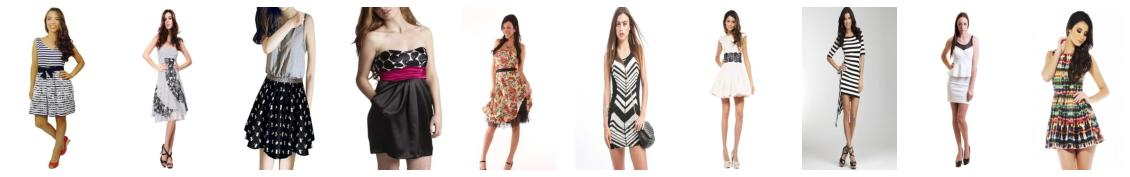

In [3]:
from search import show_images_horizontally
from pymilvus import Collection, connections
from gen_features import CLIPFeatureExtractor 
import os
import numpy as np
from PIL import Image

os.makedirs('clip_image', exist_ok=True) 
connections.connect("default", host="localhost", port="19530")
col_name = f'fashioniq'
col = Collection(col_name)
col.load()

extractor = CLIPFeatureExtractor()

image = Image.open("search3.png").convert('RGB')
featv = extractor(image).detach().cpu().numpy()
featv = featv / np.linalg.norm(featv)

image_search_params = {"metric_type": "IP", "params": {}}
results = col.search(featv, anns_field="vector", param=image_search_params, limit=10, output_fields=['filename'])
for i, result in enumerate(results[0]):
    os.system(f'cp ./pics/{result.filename}  clip_image/res{i}.jpg ')

show_images_horizontally('./clip_image', 20, 3)

Now we have searched for a dress images. Perhaps a customer would also want to try them. Since image embeddings are not very accurate for image search, they miss some details, such as the white buttons on the dress we want. Let's see if we can search for this with the given textual caption.

## Search Using CLIP Text Feature

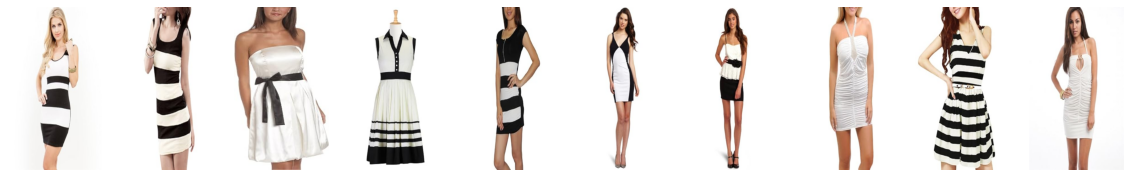

In [4]:
from search import show_images_horizontally
from gen_features import CLIPFeatureExtractor 
import os
import numpy as np

os.makedirs('clip_text', exist_ok=True) 

text = "white dress with black strip."
featt = extractor(text).detach().cpu().numpy()
featc = featt / np.linalg.norm(featt)

text_search_params = {"metric_type": "IP", "params": {}}
results = col.search(featc, anns_field="vector", param=text_search_params, limit=10, output_fields=['filename'])
for i, result in enumerate(results[0]):
    os.system(f'cp ./pics/{result.filename}  clip_text/res{i}.jpg ')

show_images_horizontally('./clip_text', 20, 3)

The top-1 result is exactly the same dress we want to search for. However, in an e-commerce scenario, users also want to check similar items for comparison. In this case, we find that the CLIP results focus on the white buttons but share less style similarity. If we can combine both results, that could create a nice set of candidates to show to the user.

## Search the Hybrid Results using RRFRankder
RRF, or Reciprocal Rank Fusion, is a method used in information retrieval to combine the results from multiple ranking systems into a single, consolidated list. This technique is particularly useful for enhancing the precision and relevance of search results by leveraging the strengths of different ranking algorithms. The principle behind RRF is straightforward: it assigns a reciprocal rank score to each item in the rankings provided by different systems, effectively prioritizing higher-ranked items while mitigating the impact of outliers or anomalies in individual systems.


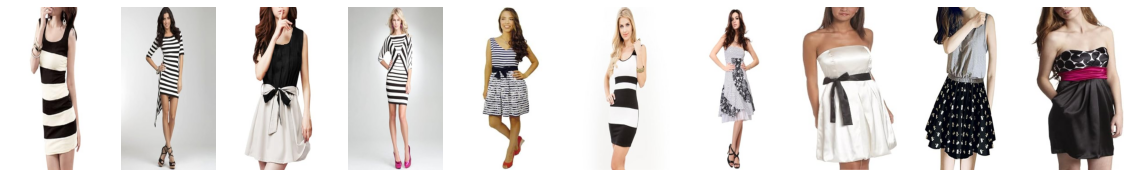

In [5]:
from search import show_images_horizontally
from pymilvus import AnnSearchRequest, RRFRanker
os.makedirs('hybrid', exist_ok=True) 

image_req = AnnSearchRequest(featv, "vector", image_search_params, limit=50)
text_req = AnnSearchRequest(featt, "vector", text_search_params, limit=50)
results = col.hybrid_search([image_req, text_req], rerank=RRFRanker(), limit=10, output_fields=['filename'])
for i, result in enumerate(results[0]):
    os.system(f'cp ./pics/{result.filename}  hybrid/res{i}.jpg ')

show_images_horizontally('./hybrid', 20, 3)


Now we can see that the integrated results not only find dresses that exactly match the description but also offer similar styles, thereby balancing exploration (finding similar items that may have advantages) and exploitation (matching the given caption details).

## Conclusion
We have now generated a hybrid search result that combines image similarity rankings based on CLIP's image and text embeddings, allowing the resulting list to be sorted according to both preferences. This means that within the system, we can design macro-level search results based on different recall algorithms, then use hybrid_search to perform integrated sorting, and automatically remove duplicates.
